In [37]:
from sklearn.datasets import fetch_20newsgroups
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
from nltk import pos_tag
import numpy as np
np.random.seed(42)
import random
random.seed(42)
import nltk
from numpy import linalg as LA

In [2]:
#newsgroups_training = fetch_20newsgroups(subset='train')

In [3]:
#pickle.dump(newsgroups_all, open( "newsgroups_training.p", "wb" ) )

In [4]:
#newsgroups_training.target.shape

QUESTION 1: To get started, plot a histogram of the number of training documents for each
of the 20 categories to check if they are evenly distributed.

In [5]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

train_dataset =fetch_20newsgroups(subset='train',categories=categories,shuffle= True,random_state=None)
test_dataset=fetch_20newsgroups(subset= 'test',categories=categories,shuffle= True,random_state=None)

target_names = train_dataset.target_names

In [6]:
category_item_count = [len(fetch_20newsgroups(categories = [name])['data']) for name in target_names]

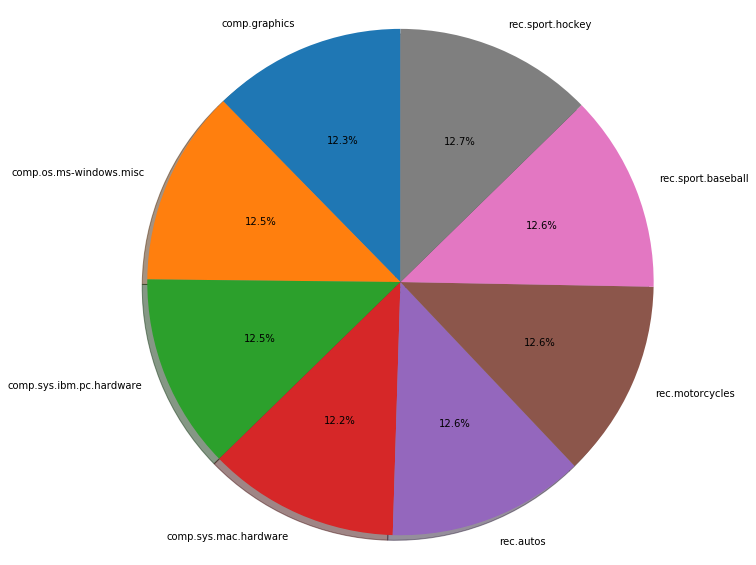

In [7]:
#plt.figure(figsize = (10,10))
fig, ax = plt.subplots(figsize = (10,10))
ax.pie(category_item_count, labels=target_names, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Text(0.5, 0, 'number of training documents')

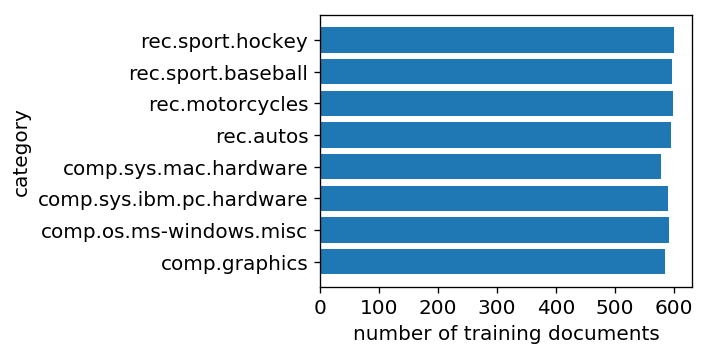

In [8]:
#plot histogram
plt.figure(figsize=(4,3),dpi=120)
plt.hist(train_dataset['target'],bins=np.arange(9)-0.5,orientation='horizontal',align='mid',rwidth=0.8)
plt.yticks(np.unique(train_dataset['target']),train_dataset['target_names'],fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('category',fontsize=12)
plt.xlabel('number of training documents',fontsize=12)

QUESTION 2: Use the following specs to extract features from the textual data:

Use the \english" stopwords of the CountVectorizer

Exclude terms that are numbers (e.g. \123", \-45", \6.7" etc.)

Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag

Use min df=3

Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [9]:
#import nltk
#nltk.download('wordnet')

In [12]:
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def lemmatize_sent_demo(text):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(nltk.word_tokenize(text))]
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

In [13]:
analyzer = CountVectorizer().build_analyzer()
def remove_num(doc):
    return [word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit()]

def remove_num_without_lemmatize(doc):
    return [word for word in (analyzer(doc)) if not word.isdigit()]

vectorizer = CountVectorizer(analyzer=remove_num,stop_words = 'english',min_df = 3)
vectorizer

CountVectorizer(analyzer=<function remove_num at 0x0000025FBF3680D0>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [14]:
tfidf_transformer = TfidfTransformer(smooth_idf=False)

X_train_count = vectorizer.fit_transform(train_dataset.data)
X_train_tfidf=tfidf_transformer.fit_transform(X_train_count)
X_test_tfidf = tfidf_transformer.transform(vectorizer.transform(test_dataset.data))
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(4732, 16600)
(3150, 16600)


In [40]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=0)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_train_recon = svd.inverse_transform(X_train_reduced)
residual_LSI = LA.norm(X_train_tfidf-X_train_recon)**2 # note LA norm is square root of what we want

# from sklearn.utils.extmath import randomized_svd
# # https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
# U, Sigma_, VT = randomized_svd(X_train_tfidf, n_components=50,n_iter=7,random_state=42)
# Sigma = np.diag(Sigma_) # convert Sigma_ to a diagnal matrix
# residual_LSI = LA.norm(X_train_tfidf-np.dot(np.dot(U,Sigma),VT))**2  #This works, but not elegant

In [41]:
print(residual_LSI)

3903.938465241574


In [42]:
from sklearn.decomposition import NMF

NMF_model = NMF(n_components=50, init='random', random_state=0)
X_train_reduced_NMF = NMF_model.fit_transform(X_train_tfidf)

In [45]:
X_train_recon_NMF = NMF_model.inverse_transform(X_train_reduced_NMF)
residual_NMF = LA.norm(X_train_tfidf-X_train_recon_NMF)**2 # note LA norm is square root of what we want
print(residual_NMF) # slighty larger variance

3949.372470527499
